In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hilmiguner","key":"37389f104083348f7e084976e5277c5a"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d rashikrahmanpritom/plant-disease-recognition-dataset
!unzip plant-disease-recognition-dataset.zip -d /content/data

Dataset URL: https://www.kaggle.com/datasets/rashikrahmanpritom/plant-disease-recognition-dataset
License(s): CC0-1.0
100% 1.25G/1.25G [00:40<00:00, 37.0MB/s]
100% 1.25G/1.25G [00:40<00:00, 33.3MB/s]
Archive:  plant-disease-recognition-dataset.zip
  inflating: /content/data/Test/Test/Healthy/8ddaa5a5caa5caa8.jpg  
  inflating: /content/data/Test/Test/Healthy/8ddaac1bd6c8cd0a.jpg  
  inflating: /content/data/Test/Test/Healthy/8ddd5ec1c0de38c4.jpg  
  inflating: /content/data/Test/Test/Healthy/8def3f60308ab41b.jpg  
  inflating: /content/data/Test/Test/Healthy/8def4d91382175c3.jpg  
  inflating: /content/data/Test/Test/Healthy/8df452e2e38c0b6e.jpg  
  inflating: /content/data/Test/Test/Healthy/8dfae9d78cc32089.jpg  
  inflating: /content/data/Test/Test/Healthy/8e3dbccdfe08c850.jpg  
  inflating: /content/data/Test/Test/Healthy/8e68163c62dc57d5.jpg  
  inflating: /content/data/Test/Test/Healthy/8e6a823cce9ff40c.jpg  
  inflating: /content/data/Test/Test/Healthy/8e77857194a59a87.jpg  
  in

In [5]:
import os

def total_files(folder_path):
    num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    return num_files

train_files_healthy = "/content/data/Train/Train/Healthy"
train_files_powdery = "/content/data/Train/Train/Powdery"
train_files_rust = "/content/data/Train/Train/Rust"

test_files_healthy = "/content/data/Test/Test/Healthy"
test_files_powdery = "/content/data/Test/Test/Powdery"
test_files_rust = "/content/data/Test/Test/Rust"

valid_files_healthy = "/content/data/Validation/Validation/Healthy"
valid_files_powdery = "/content/data/Validation/Validation/Powdery"
valid_files_rust = "/content/data/Validation/Validation/Rust"

In [6]:
print("Number of healthy leaf images in training set", total_files(train_files_healthy))
print("Number of powder leaf images in training set", total_files(train_files_powdery))
print("Number of rusty leaf images in training set", total_files(train_files_rust))

print("========================================================")

print("Number of healthy leaf images in test set", total_files(test_files_healthy))
print("Number of powder leaf images in test set", total_files(test_files_powdery))
print("Number of rusty leaf images in test set", total_files(test_files_rust))

print("========================================================")

print("Number of healthy leaf images in validation set", total_files(valid_files_healthy))
print("Number of powder leaf images in validation set", total_files(valid_files_powdery))
print("Number of rusty leaf images in validation set", total_files(valid_files_rust))

Number of healthy leaf images in training set 458
Number of powder leaf images in training set 430
Number of rusty leaf images in training set 434
Number of healthy leaf images in test set 50
Number of powder leaf images in test set 50
Number of rusty leaf images in test set 50
Number of healthy leaf images in validation set 20
Number of powder leaf images in validation set 20
Number of rusty leaf images in validation set 20


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri artırma ve normalizasyon
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/data/Train/Train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    '/content/data/Validation/Validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1322 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [8]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.2 MB/s eta 0:00:00


In [9]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras import layers


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [10]:
base_model = MobileNetV3Large(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

for layer in base_model.layers:
  layer.trainable = False

12683000/12683000 [==============================] - 1s 0us/step


In [11]:
x = layers.Flatten()(base_model.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

from keras.optimizers import Adam
from keras.metrics import Precision, Recall
import tensorflow_addons as tfa

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        tfa.metrics.F1Score(num_classes=3, average='micro', name='f1_score')
    ]
)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                                    

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
41/41 [==============================] - 110s 2s/step - loss: 1.5008 - accuracy: 0.3729 - precision: 0.3689 - recall: 0.2814 - f1_score: 0.3729 - val_loss: 1.7581 - val_accuracy: 0.2812 - val_precision: 0.2812 - val_recall: 0.2812 - val_f1_score: 0.2812
Epoch 2/20
41/41 [==============================] - 104s 3s/step - loss: 1.3547 - accuracy: 0.3519 - precision: 0.3625 - recall: 0.2729 - f1_score: 0.3519 - val_loss: 1.1569 - val_accuracy: 0.3125 - val_precision: 0.2692 - val_recall: 0.2188 - val_f1_score: 0.3125
Epoch 3/20
41/41 [==============================] - 95s 2s/step - loss: 1.2130 - accuracy: 0.3915 - precision: 0.4271 - recall: 0.2860 - f1_score: 0.3915 - val_loss: 0.9991 - val_accuracy: 0.5625 - val_precision: 0.6923 - val_recall: 0.2812 - val_f1_score: 0.5625
Epoch 4/20
41/41 [==============================] - 92s 2s/step - loss: 1.2383 - accuracy: 0.4101 - precision: 0.4196 - recall: 0.2853 - f1_score: 0.4101 - val_loss: 0.9960 - val_accuracy: 0.5000 - val_prec

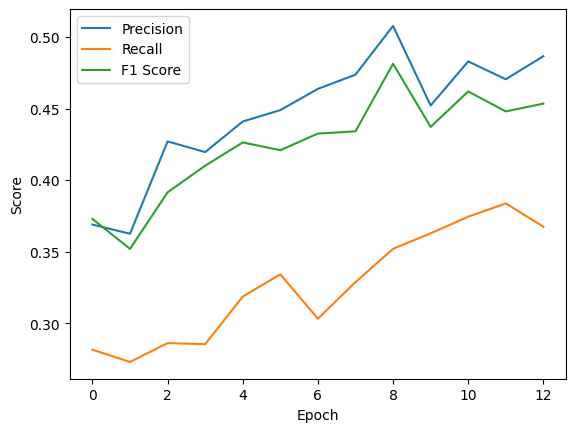

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['precision'], label='Precision')
plt.plot(history.history['recall'], label='Recall')
plt.plot(history.history['f1_score'], label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.show()


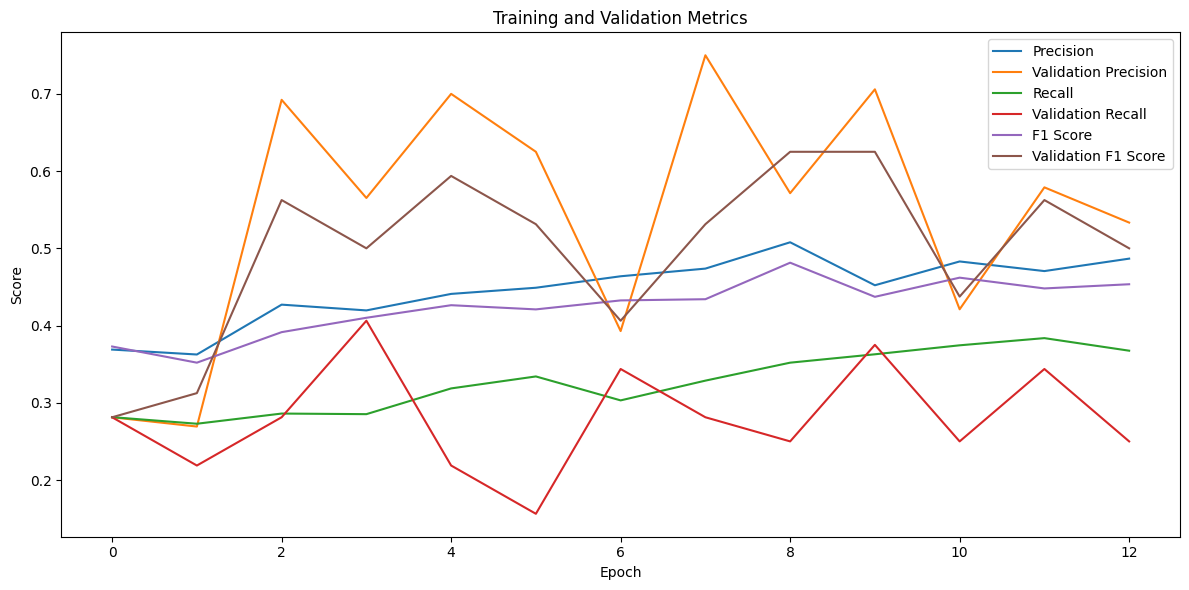

In [15]:
import matplotlib.pyplot as plt

# Metriklerin Görselleştirilmesi
plt.figure(figsize=(12, 6))
plt.plot(history.history['precision'], label='Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.plot(history.history['recall'], label='Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.plot(history.history['f1_score'], label='F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.title('Training and Validation Metrics')

plt.tight_layout()
plt.show()


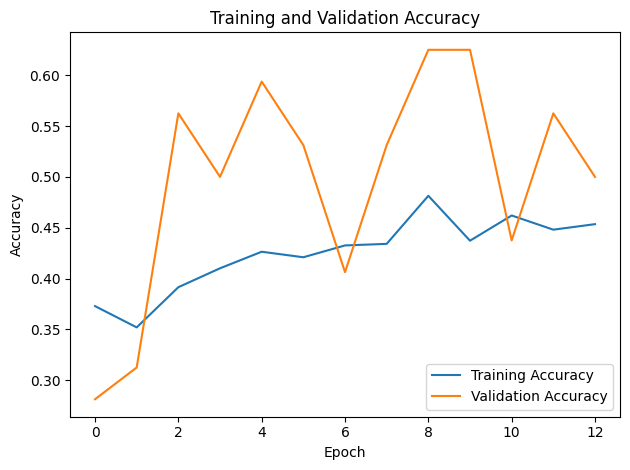

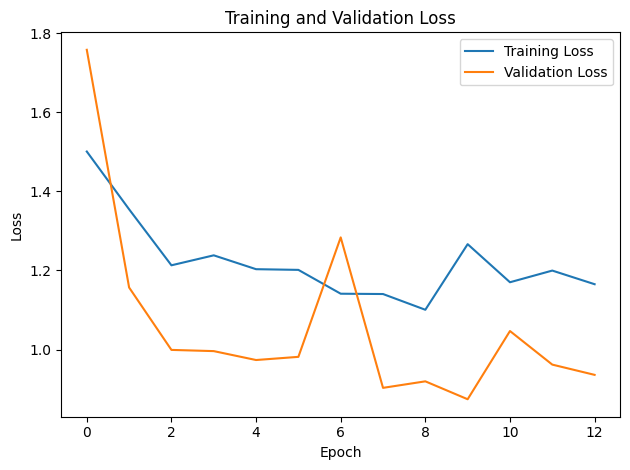

In [16]:
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [19]:
# Test veri setini yükleyin ve ön işleme yapın (ör. boyutunu yeniden şekillendirme, normalleştirme vb.)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/data/Test/Test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Verilerin karıştırılmaması için shuffle=False yapın
)

# Modeli test veri seti üzerinde değerlendirin
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1_score)


Found 150 images belonging to 3 classes.
5/5 [==============================] - 12s 2s/step - loss: 0.9126 - accuracy: 0.5800 - precision: 0.7229 - recall: 0.4000 - f1_score: 0.5800
Test Loss: 0.9125569462776184
Test Accuracy: 0.5799999833106995
Test Precision: 0.7228915691375732
Test Recall: 0.4000000059604645
Test F1 Score: 0.5799999833106995


5/5 [==============================] - 11s 2s/step


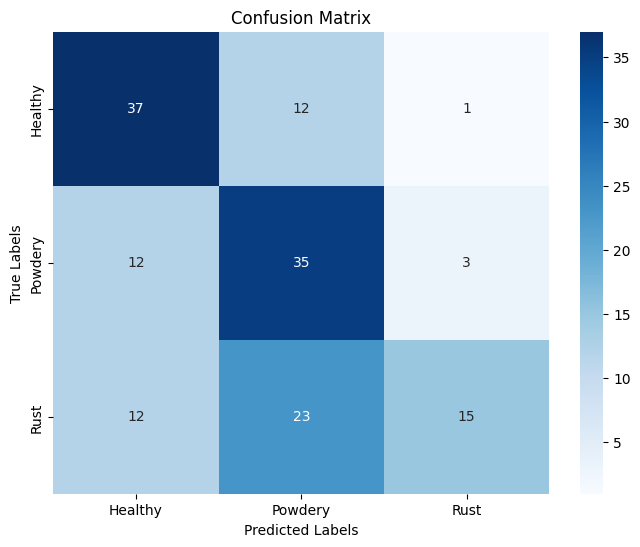

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Test veri setinden tahminleri ve gerçek etiketleri alın
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Konfüzyon matrisini oluşturun
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Sınıf etiketlerini alın
class_labels = list(test_generator.class_indices.keys())

# Konfüzyon matrisini görselleştirin
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [21]:
total_samples = len(test_generator) * test_generator.batch_size
print(total_samples)

160


10/10 [==============================] - 1s 41ms/step


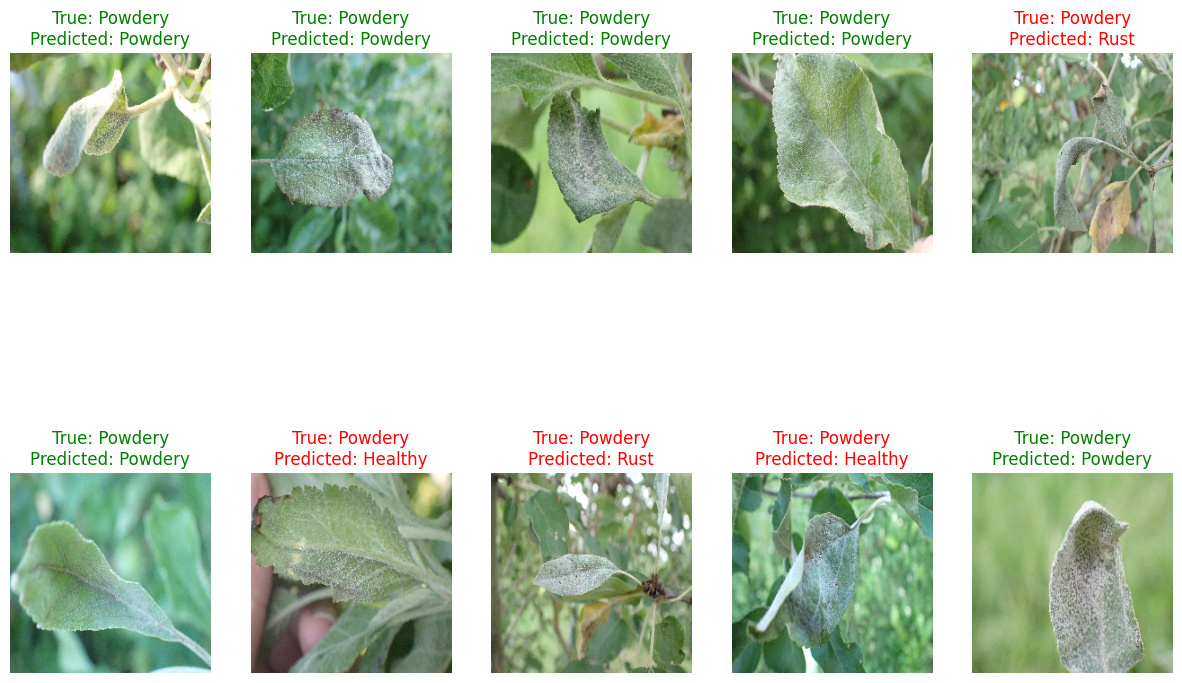

In [22]:
import random

# Test veri setindeki toplam örnek sayısını alın
total_samples = len(test_generator) * test_generator.batch_size

# Rastgele 10 resim seçin
random_indices = random.sample(range(total_samples), min(10, total_samples))
sample_images = []
sample_labels = []

for idx in random_indices:
    batch_images, batch_labels = test_generator[idx % len(test_generator)]  # Mod işlemi, indeksi döngüye alır
    sample_images.extend(batch_images)
    sample_labels.extend(batch_labels)

sample_images = np.array(sample_images)
sample_labels = np.array(sample_labels)

# Model tarafından yapılan tahminleri alın
predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)

# Resimlerin ve tahminlerin görselleştirilmesi
plt.figure(figsize=(15, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i])
    true_label = class_labels[np.argmax(sample_labels[i])]
    predicted_label = class_labels[predicted_classes[i]]
    if true_label == predicted_label:
        color = 'green'
    else:
        color = 'red'
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}', color=color)
    plt.axis('off')
plt.show()


1/1 [==============================] - 0s 55ms/step


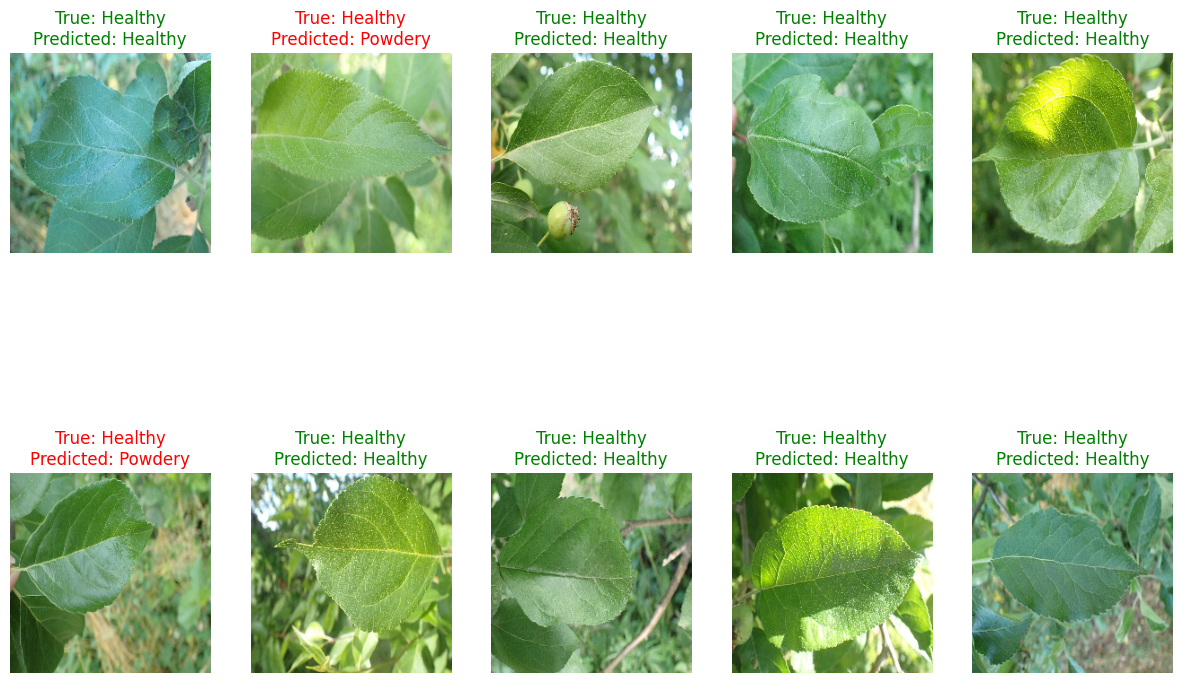

In [23]:
import matplotlib.pyplot as plt

# Test veri setinden bir örnek resim seçin
sample_images, sample_labels = next(test_generator)

# Model tarafından yapılan tahminleri alın
predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)

# Resimlerin ve tahminlerin görselleştirilmesi
plt.figure(figsize=(15, 10))
for i in range(10):  # İlk 10 resmi görselleştirin
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i])
    true_label = class_labels[np.argmax(sample_labels[i])]
    predicted_label = class_labels[predicted_classes[i]]
    if true_label == predicted_label:
        color = 'green'
    else:
        color = 'red'
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}', color=color)
    plt.axis('off')
plt.show()


In [24]:
model.save('plant_disease_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
